# Data Exploration

In [1]:
# Packages
import numpy as np
import pandas as pd
from zipfile import ZipFile

In [2]:
import matplotlib.pyplot as plt

In [3]:
! pip install fastprogress
from fastprogress import master_bar, progress_bar

## Loading data
Data available at link: https://www.kaggle.com/CooperUnion/anime-recommendations-database

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
PATH_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/graph_based_recommendation_system'
%cd {PATH_FOLDER}

/content/gdrive/.shortcut-targets-by-id/1LXaLcRw6J7FDGD0zFUuJmFiE_7qFyu6a/graph_based_recommendation_system


In [6]:
%ls

DataExploration.ipynb  project_proposal.docx  README.md
dataset.zip            project_proposal.pdf


In [7]:
# Loading dataset from .zip file
path_dataset = "dataset.zip"

with ZipFile(path_dataset, 'r') as zip_ref:
    all_path = zip_ref.namelist()
    print('Paths: ', all_path)
    
    df_anime = pd.read_csv(zip_ref.open(all_path[0]))
    df_rating = pd.read_csv(zip_ref.open(all_path[1]))

Paths:  ['anime.csv', 'rating.csv']


### Anime

In [8]:
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


### Rating

In [9]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Basic statistics

In [10]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items

print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  84715
Number of edges:  7813737


## Pre-processing

Elimination of rows that have Nan values

In [11]:
df_anime.dropna(inplace=True)
df_rating.dropna(inplace=True)

Elimination of all user-item iteraction when a rate has not been given (rating = -1)

In [12]:
# number of user that have seen an anime, but didn't give a rate (meaning rating = -1)
df_rating[df_rating['rating'] == -1].rating.value_counts()

-1    1476496
Name: rating, dtype: int64

In [13]:
# new dataframe without user-item itercations with rating = -1
new_df_rating = df_rating[df_rating['rating'] != -1]
assert(new_df_rating.shape[0] == df_rating.shape[0] - 1476496)

df_rating = new_df_rating
del new_df_rating

Number of possible nodes and edges after the pre-processing phase

In [14]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items

print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  79527
Number of edges:  6337241


## Anime by genre

In [15]:
def search_gerne(df_iteractions, df_description, feature, verbose=0):
    '''
    Function to search all items that have 'feature' in one column of dataframe
    df_description (column 'gerne' in this case) and search all corresponding 
    iteractions on df_iteractions
    -------------
    Return:
      Dataframe df_result             All iteractions whose item has feature
    '''
    
    # Creation of a item list with gerne = feature
    item_list = [] # anime_list
    for i in range(df_description.shape[0]):
        if feature in df_description.iloc[i,2].split(', '):
            item_list.append(df_description.iloc[i,0])
            
    if verbose: print('Number of Items - {}: {}'.format(feature, len(item_list)))
    
    
    
    # Search anime found before in df_iteractions
    iteraction_list = []
    for i in item_list:
        _ = df_iteractions[df_iteractions['anime_id'] == i].index
        iteraction_list.extend(_)
        
    if verbose: print('Number of Iteractions - {}: {}'.format(feature, len(iteraction_list)))
    
    return df_iteractions.loc[iteraction_list, :]

In [16]:
# Creation of a list for all anime genres
gerne_list = []

for i in progress_bar(range(df_anime.shape[0])):
  _ = df_anime.iloc[i,2].split(', ')
  gerne_list.extend(_)

gerne_list = list(set(gerne_list))

print('Number of genres: ', len(gerne_list))
print('Genres:\n', gerne_list)

Number of genres:  43
Genres:
 ['Martial Arts', 'Parody', 'Shoujo Ai', 'Space', 'Comedy', 'Dementia', 'Military', 'Shounen Ai', 'Hentai', 'Shounen', 'Shoujo', 'Vampire', 'Harem', 'Kids', 'Yuri', 'Action', 'Sports', 'Ecchi', 'Magic', 'Police', 'Josei', 'Adventure', 'Sci-Fi', 'Cars', 'Supernatural', 'Music', 'School', 'Yaoi', 'Demons', 'Historical', 'Romance', 'Psychological', 'Game', 'Mecha', 'Mystery', 'Seinen', 'Super Power', 'Fantasy', 'Horror', 'Drama', 'Slice of Life', 'Thriller', 'Samurai']


In [17]:
# Count how much intercations we have on df_rating given a genre
gerne_counts = []
for g in progress_bar(gerne_list):
  _ = search_gerne(df_rating, df_anime, g)
  gerne_counts.append(_.shape[0])

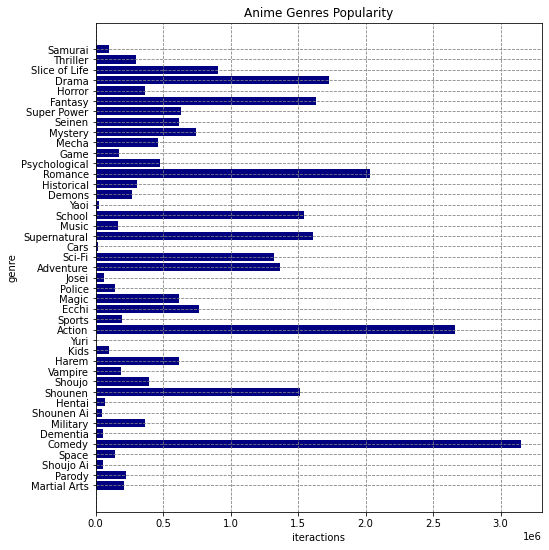

In [26]:
fig, ax = plt.subplots(figsize=(8,9))

ax.barh(np.arange(len(gerne_list)), gerne_counts, color='navy')

ax.set_yticks(np.arange(len(gerne_list)))
ax.set_yticklabels(gerne_list)
ax.set_title('Anime Genres Popularity')
ax.set_xlabel('iteractions')
ax.set_ylabel('genre')
plt.grid(color='grey', linestyle='--')

plt.savefig('/figures/anime_genres_popularity.jpg')

plt.show()